In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
from scipy.stats import uniform as sp_rand
from scipy.stats import randint as sp_randint
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import pickle

## 6. Model

In [2]:
# data
dt_model = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/data/dt_all_eng.csv")
# IDs
IDs_train = pickle.load(open("../../data/Mercedes_Benz_Greener_Manufacturing/data/IDs_train.pkl", "rb"))
IDs_test = pickle.load(open("../../data/Mercedes_Benz_Greener_Manufacturing/data/IDs_test.pkl", "rb"))
# cols
cols_cat = pickle.load(open("../../data/Mercedes_Benz_Greener_Manufacturing/data/cols_cat.pkl", "rb"))

In [3]:
# r_2 for xgboost
def r_2(preds, dtrain):
    labels = dtrain.get_label()
    return 'score', r2_score(labels, preds)

In [4]:
# remove ohe
dt_model_features = dt_model.drop(dt_model.filter(regex = "Encode_ohe").columns, axis = 1)
dt_model_features.shape

(8418, 697)

In [5]:
# X, y, ID
X_train_all = dt_model_features.loc[dt_model_features["ID"].isin(IDs_train)].drop(["y"], axis = 1)
X_test = dt_model_features.loc[dt_model_features["ID"].isin(IDs_test)].drop(["y"], axis = 1)
y_train_all = dt_model_features.loc[dt_model_features["ID"].isin(IDs_train)].y.values
y_test = dt_model_features.loc[dt_model_features["ID"].isin(IDs_test)].y.values

In [6]:
ID_test = dt_model_features.loc[dt_model_features["ID"].isin(IDs_test)].ID.values

In [7]:
X_train_all.shape

(4209, 696)

### 6.1 xgboost

In [8]:
params_xgb = {
    "objective": "reg:linear"
    , "booster": "gbtree"
    , "learning_rate": 0.005
    , "subsample": .9
    , "colsample": .8
    , "max_depth": 2
    , "alpha": 1
    , "lambda": 2
    , "gamma": 20
    , "base_score": np.mean(y_train_all)
}

In [9]:
# xgbDmatrix
dtrain = xgb.DMatrix(X_train_all, y_train_all)
dtest = xgb.DMatrix(X_test)

In [17]:
X_train_all.head()

,ID_Norm,X10,single_train_dup_train_X11,X12,X13,X14,dup_test_X15,X16,dup_train_X17,X18,...,DR_SRP_All_41,DR_SRP_All_42,DR_SRP_All_43,DR_SRP_All_44,DR_SRP_All_45,DR_SRP_All_46,DR_SRP_All_47,DR_SRP_All_48,DR_SRP_All_49,DR_SRP_All_50
0,-1.731845,-0.128145,-0.0109,-0.284174,3.975223,-0.865036,-0.024379,-0.051189,-0.090909,10.476791,...,-4.310734,5.945329,-2.559604,31.135665,0.293209,0.603304,-23.533664,0.178004,8.136958,31.094124
1,0.638871,-0.128145,-0.0109,-0.284174,-0.251558,-0.865036,-0.024379,-0.051189,-0.090909,-0.095449,...,-0.702463,4.436041,0.581625,-0.544789,-1.260347,0.603304,0.655181,-1.686563,-0.986538,0.841992
2,0.689076,-0.128145,-0.0109,-0.284174,-0.251558,-0.865036,-0.024379,-0.051189,-0.090909,10.476791,...,-7.149498,-3.792362,-0.857216,4.168977,-2.427348,-7.529943,0.152561,2.048677,5.461848,-2.828128
3,-0.525294,-0.128145,-0.0109,-0.284174,-0.251558,1.156022,-0.024379,-0.051189,-0.090909,-0.095449,...,-0.274350,-1.298232,0.515624,0.771879,-0.104163,0.603304,1.549413,-1.686563,-0.088339,1.550131
6,0.027365,-0.128145,-0.0109,-0.284174,-0.251558,-0.865036,-0.024379,-0.051189,-0.090909,-0.095449,...,0.031936,-0.520623,0.364371,0.771879,-0.101286,1.825981,0.380033,-0.518769,-2.490434,1.643128


In [10]:
# cv
cv_xgb = xgb.cv(params_xgb, dtrain
                , num_boost_round = 5000
                , nfold = 10
                , feval = r_2, maximize = True, early_stopping_rounds = 50
                , show_stdv = True, verbose_eval = 50, seed = 888)

[0]	train-rmse:12.6511+0.0943949	train-score:0.0055764+8.05968e-05	test-rmse:12.6251+0.81816	test-score:0.0048737+0.00129349
[50]	train-rmse:11.1682+0.101309	train-score:0.225043+0.00339242	test-rmse:11.1394+0.875652	test-score:0.22633+0.0228808
[100]	train-rmse:10.1624+0.109746	train-score:0.358353+0.00540706	test-rmse:10.1305+0.924217	test-score:0.360634+0.0358463
[150]	train-rmse:9.49984+0.117121	train-score:0.439292+0.00665692	test-rmse:9.46637+0.961022	test-score:0.441899+0.0437682
[200]	train-rmse:9.07345+0.122771	train-score:0.488494+0.00741723	test-rmse:9.04044+0.986548	test-score:0.490998+0.0487045
[250]	train-rmse:8.80253+0.126456	train-score:0.518582+0.00783944	test-rmse:8.77554+1.00333	test-score:0.520317+0.0518896
[300]	train-rmse:8.62636+0.129495	train-score:0.537657+0.00816212	test-rmse:8.61229+1.01493	test-score:0.537907+0.054065
[350]	train-rmse:8.50466+0.131998	train-score:0.550608+0.00841304	test-rmse:8.50649+1.02339	test-score:0.549114+0.0555743
[400]	train-rmse:8.4

In [11]:
# train
model_xgb = xgb.train(params_xgb, dtrain, num_boost_round = cv_xgb.shape[0])

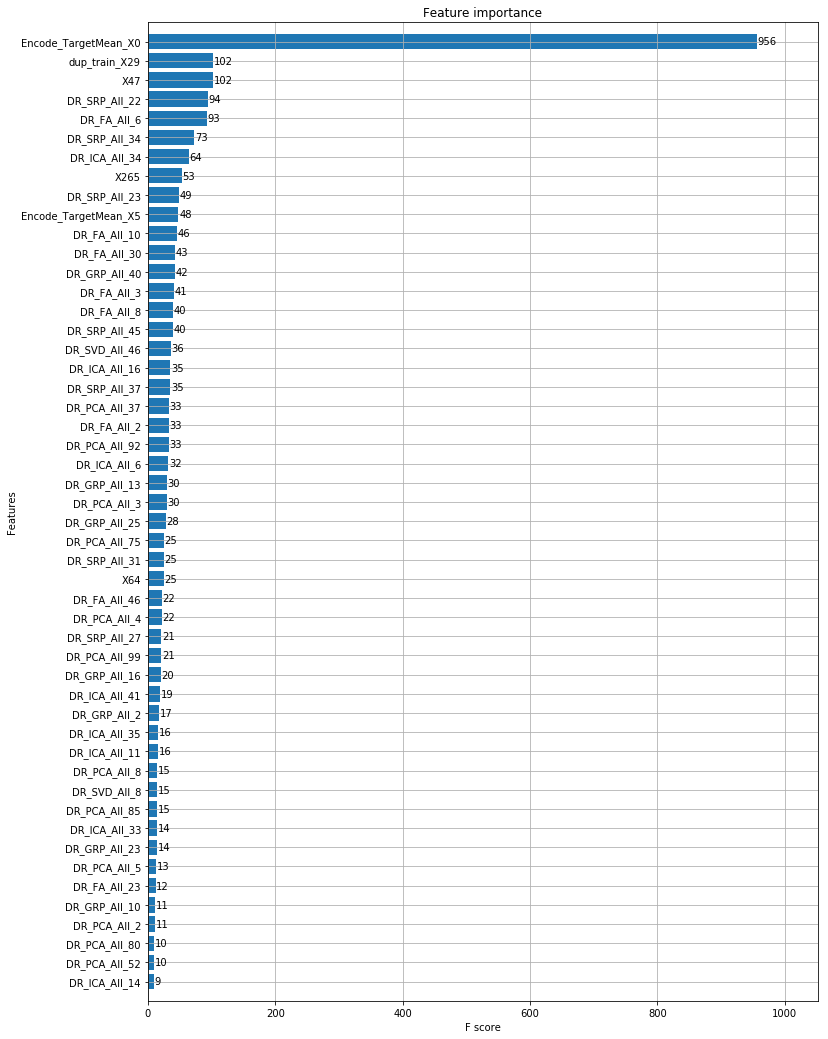

In [12]:
# importance
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model_xgb, max_num_features = 50, height = 0.8, ax = ax)
plt.show()

In [13]:
# predict
y_test = model_xgb.predict(dtest)
y_test[:10]

array([  94.2232666 ,   94.52567291,   94.40810394,  111.29228973,
        111.26741791,   94.55152893,   94.55152893,   94.16348267,
         93.79803467,  111.65014648], dtype=float32)

In [14]:
# submit
dt_submit = pd.DataFrame({"ID": ID_test, "y": y_test})
dt_submit.head()

,ID,y
0,2849,94.223267
1,2710,94.525673
2,4077,94.408104
3,7454,111.292290
4,7484,111.267418


In [15]:
dt_submit.shape

(4209, 2)

In [16]:
# dt_submit.to_csv("../../data/Mercedes_Benz_Greener_Manufacturing/submission/19_cleaned_python.csv", index = False)